<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Fast image retrieval

In the notebook [01_training_and_evaluation_introduction.ipynb](01_training_and_evaluation_introduction.ipynb) we perform image retrieval by computing the distances between a query image and *all* reference images. While computing the L2 distance between two images is fast, for large datasets of tens of thousands of images this exhaustive search can be a bottleneck for real-time applications.

To speed up image retrieval, this notebook shows how to implement an approximate nearest neighbor method designed to work well for large datasets (N) and high-dimensional features (D). For example, the well-known Ball Tree approach has a complexity of O\[D\*log(N)\], compared to O\[D\*N\] for exhaustive search. 

## Initialization

In [1]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Standard python libraries
import sys
import numpy as np
from pathlib import Path
import random
import scrapbook as sb
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

# Fast.ai
import fastai
from fastai.vision import (
    load_learner,
    cnn_learner,
    DatasetType,
    ImageList,
    imagenet_stats,
    models,
)

# Computer Vision repository
sys.path.extend([".", "../.."])  # to access the utils_cv library
from utils_cv.classification.data import Urls
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor, db_num_workers
from utils_cv.similarity.metrics import compute_distances
from utils_cv.similarity.model import compute_features_learner
from utils_cv.similarity.plot import plot_distances, plot_ranks_distribution

In [3]:
print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.48
Fast.ai (Torch) is using GPU: Tesla V100-PCIE-16GB


## Data preparation
We start with parameter specifications and data preparation. We use the *Fridge objects* dataset, which is composed of 134 images, divided into 4 classes: can, carton, milk bottle and water bottle. 

In [4]:
# Data location
DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)

# Image reader configuration
BATCH_SIZE = 16
IM_SIZE = 300

# Number of comparison of nearest neighbor versus exhaustive search for accuracy computation
NUM_RANK_ITER = 100

In [5]:
# Load images into fast.ai's ImageDataBunch object
random.seed(642)
data = (
    ImageList.from_folder(DATA_PATH)
    .split_by_rand_pct(valid_pct=0.8, seed=20)
    .label_from_folder()
    .transform(size=IM_SIZE)
    .databunch(bs=BATCH_SIZE, num_workers = db_num_workers())
    .normalize(imagenet_stats)
)
print(f"Training set: {len(data.train_ds.x)} images, validation set: {len(data.valid_ds.x)} images")

Training set: 27 images, validation set: 107 images


## Load model

Below we load a [ResNet18](https://arxiv.org/pdf/1512.03385.pdf) CNN from fast.ai's library which is pre-trained on ImageNet.

In [6]:
learn = cnn_learner(data, models.resnet18, ps=0)

Alternatively, one can load a model which was trained using the [01_training_and_evaluation_introduction.ipynb](01_training_and_evaluation_introduction.ipynb) notebook using these lines of code:
```python
    learn = load_learner(".", 'image_similarity_01_model')
    learn.data = data
```

## Feature extraction

We now compute the DNN features for each image in our validation set. We use the output of the penultimate layer as our image representation, which, for the Resnet-18 model has a dimensionality of 512 floating point values.

In [7]:
# Use penultimate layer as image representation
embedding_layer = learn.model[1][-2] 
print(embedding_layer)

BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [8]:
# Compute DNN features for all validation images
valid_features = compute_features_learner(data, DatasetType.Valid, learn, embedding_layer)
print(f"Computed DNN features for the {len(list(valid_features))} validation images,\
each consisting of {len(valid_features[list(valid_features)[0]])} floating point values.")

Computed DNN features for the 107 validation images,each consisting of 512 floating point values.


## Image Retrieval Example
In the cells below, we demonstrate how to do fast image retrieval using scikit-learn's [NearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html) implementation. Note that we use the same approach to computing distances as in the [01_training_and_evaluation_introduction.ipynb](01_training_and_evaluation_introduction.ipynb) notebook, i.e. we normalize the feature vectors to be of unit length, and chose "Euclidean" distance.

First, we build a nearest neighbor object using appropriately normalized features.

In [9]:
# Normalize all reference features to be of unit length
valid_features_list = np.array(list(valid_features.values()))
valid_features_list /= np.linalg.norm(valid_features_list, axis=1)[:,None]

# Build nearest neighbor object using the reference set
nn = NearestNeighbors(algorithm='auto', metric='euclidean', n_neighbors=min(100,len(valid_features_list)))
nn.fit(valid_features_list)
nn

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                 radius=1.0)

Next, we pick a query image and get its DNN representation.

In [10]:
query_im_path =  str(data.valid_ds.items[1])
query_feature = valid_features[query_im_path]
print(f"Query image path: {query_im_path}")
print(f"Query feature dimension: {len(query_feature)}")
assert len(query_feature) == 512 # For Resnet-18 model

Query image path: C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjects\carton\47.jpg
Query feature dimension: 512


Finally, we use the nearest neighbor object for image retrieval. It is important that the query feature is normalized in exactly the same way as the features used to initilize the nearest-neighbor object.

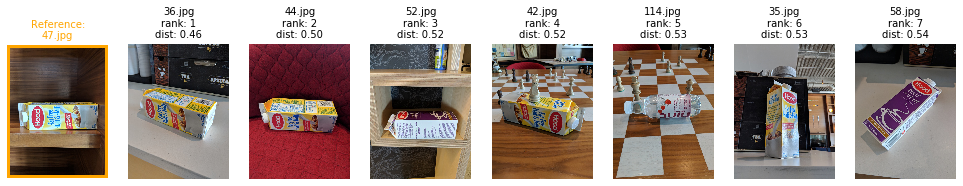

In [11]:
# Normalize the query feature vector to be of unit length
query_feature /= np.linalg.norm(query_feature, 2)
query_feature = np.reshape(query_feature, (-1, len(query_feature)))

# Query the nearest neighbor object to find the top most similar reference images
approx_distances, approx_im_indices = nn.kneighbors(query_feature)

# Display the results
approx_im_paths = [str(data.valid_ds.items[i]) for i in approx_im_indices[0]]
plot_distances(list(zip(approx_im_paths, approx_distances[0])), 
               num_rows=1, num_cols=8, figsize=(17,5))

In [12]:
# Compute features for the training set from which query images will be randomly selected
train_features = compute_features_learner(data, DatasetType.Train, learn, embedding_layer)
print(f"Computed DNN features for the {len(list(train_features))} training images, \
each consisting of {len(train_features[list(train_features)[0]])} floating point values.")

Computed DNN features for the 27 training images, each consisting of 512 floating point values.


## Retrieval speed

This section compares retrieval times of exhaustive search versus approximate nearest neighbor search by running the respective algorithms multiple times. 

Exhaustive search is fast for the small dataset provided with this notebook. However, when using even a modestly sized dataset of 5,000 images, exhaustive-search takes already 0.1 seconds per query while nearest-neighbor search takes 5ms, a 20 times speedup at virtually no loss in accuracy. For a dataset with 100,000 images, exhaustive search increases to 2.1 seconds, while our nearest neighbor search remains 20 times faster.

More speed-gains (however possibly at the loss of retrieval accuracy) can be gained by selecting different parameters for the *NearestNeighbors* object. For information on this topic see the [scikit-learn site](https://scikit-learn.org/stable/modules/neighbors.html).

In [13]:
%%timeit
query_im_path = str(np.random.choice(data.train_ds.items))
query_feature = train_features[query_im_path]
distances = compute_distances(query_feature, valid_features)

2.25 ms ± 49.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%%timeit
query_im_path = str(np.random.choice(data.train_ds.items))
query_feature = train_features[query_im_path]
query_feature /= np.linalg.norm(query_feature, 2)
query_feature = np.reshape(query_feature, (-1, len(query_feature)))
approx_distances, approx_im_indices = nn.kneighbors(query_feature)

613 µs ± 55.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Retrieval accuracy

Nearest neighbor methods are much faster than brute-force search, however can sometimes be incorrect. That is, given a query image, the most similar image as returned by the nearest neighbor object does in fact not have the lowest L2 distance.

To measure retrieval accuracy we use brute-force search to find the *true* image with lowest distance, and then compare at what rank our nearest neighbor search places this image. Ideally we would like the approximate nearest neighbor method to also identify the *true* image as the one with minimum distance, ie have a rank of 1. The higher the rank, the worse.

The code below computes the average of this rank using 100 randomly and independently selected query images. Interestingly, even when using a large dataset of 100,000 images, we found that in the majority of cases the output of the nearest neighbor search is identical (but much faster) compared to brute-force.

In [15]:
ranks = []
for iter in tqdm(range(NUM_RANK_ITER)):
    
    # Get random query image
    query_im_path = str(np.random.choice(data.train_ds.items))
    query_feature = train_features[query_im_path]
    assert len(query_feature) == 512

    # Find closest match (ie. most similar image) using brute-force search 
    bf_distances_and_paths = compute_distances(query_feature, valid_features)
    bf_distances = [d for (p,d) in bf_distances_and_paths]
    bf_closest_match_path = bf_distances_and_paths[np.argmin(bf_distances)][0]

    # Find closest match (ie. most similar image) using nearest-neighbor search
    query_feature /= np.linalg.norm(query_feature, 2)
    query_feature = np.reshape(query_feature, (-1, len(query_feature)))
    approx_distances, approx_im_indices = nn.kneighbors(query_feature)

    # Find at what position (ie rank) the brute-force result is within the nearest-neighbor search result
    # Best: rank 1. 
    approx_im_paths = [str(data.valid_ds.items[i]) for i in approx_im_indices[0]]
    rank = np.where(np.array(approx_im_paths) == bf_closest_match_path)[0] 
    assert len(rank) == 1
    assert approx_im_paths[int(rank)] == bf_closest_match_path
    ranks.append(float(rank)+1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 179.54it/s]


In [16]:
print(f"The median rank over {len(ranks)} runs with {len(valid_features)} reference images is {np.median(ranks)}, and average rank is {np.mean(ranks)}.")

The median rank over 100 runs with 107 reference images is 1.0, and average rank is 1.0.


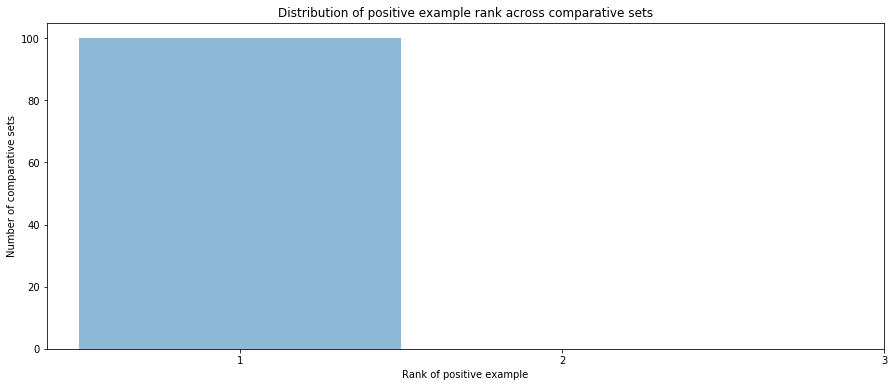

In [17]:
# Display the distribution of ranks
plot_ranks_distribution(ranks)

In [18]:
# Log some outputs using scrapbook which are used during testing to verify correct notebook execution
sb.glue("feature_dimension", len(query_feature[0]))
sb.glue("median_rank", np.median(ranks))